In [19]:
!nvidia-smi

Mon Apr  4 14:50:24 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.91.03    Driver Version: 460.91.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 5000     Off  | 00000000:00:05.0 Off |                  Off |
| 33%   38C    P2    49W / 230W |   1830MiB / 16125MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [20]:
import os
import pickle
import json

import requests

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

import torch
from torch import nn
from torch.optim import Adam

from transformers import BertTokenizer, BertModel

from tqdm import tqdm

In [21]:
np.random.seed(42)

EPOCHS = 20
BATCH_SIZE = 16
LR = 1e-6

## Load Data

In [22]:
paths = pickle.load(open('data/science/paths.pkl', 'rb'))

In [23]:
def ff(path_str):
    id = path_str[:-1]
    if path_str[-1] == 'r':
        return paths[id]['reverse']
    else:
        return paths[id]['forward']
def fff(ans):
    paths_str = ans.split('_')
    return {
        'A': ff(paths_str[0]),
        'B': ff(paths_str[1]),
        'better': 'A' if paths_str[2] == paths_str[0] else 'B'
    }
    return list(map(ff, paths_str))
with open('data/science/answers.txt', 'r') as f:
    answers = list(map(fff, filter(lambda x: len(x) > 0, f.read().split('\n'))))

In [24]:
answers[0]['A']

{'text': 'Piece is a type of Part. Part is related to Car. you are likely to find Car in/at/on Land. ',
 'short': 'Piece --IsA--> Part <--RelatedTo--> Car --AtLocation--> Land '}

In [25]:
answers[0]['B']

{'text': 'Dream is related to Day. Day is related to Measurement. Measurement is related to Year. ',
 'short': 'Dream <--RelatedTo--> Day <--RelatedTo--> Measurement <--RelatedTo--> Year '}

In [26]:
answers[0]['better']

'A'

In [27]:
text_arr = []
label_arr = []

for ans in answers:
#     text_arr.append(ans['A']['text'])
#     text_arr.append(ans['B']['text'])
#     if ans['better'] == 'A':
#         label_arr.append(1)
#         label_arr.append(0)
#     else:
#         label_arr.append(0)
#         label_arr.append(1)
    text_arr.append(ans['A']['text'] + ans['B']['text'])
    text_arr.append(ans['B']['text'] + ans['A']['text'])
    if ans['better'] == 'A':
        label_arr.append(1)
        label_arr.append(0)
    else:
        label_arr.append(0)
        label_arr.append(1)

In [28]:
data_df = pd.DataFrame(data={
    'Text': text_arr,
    'Label': label_arr,
})

In [29]:
train_df, val_df, test_df = np.split(data_df.sample(frac=1, random_state=42), [int(.8*len(data_df)), int(.9*len(data_df))])

print(len(train_df),len(val_df), len(test_df))

22080 2760 2760


In [30]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

class Dataset(torch.utils.data.Dataset):
    def __init__(self, df, text_col='Text', label_col='Label'):
        self.labels = [float(x) for x in df[label_col]]
        self.texts = [
            tokenizer(
                text, 
                padding='max_length',
                max_length = 512,
                truncation=True,
                return_tensors='pt'
            ) for text in df[text_col]
        ]
    def classes(self):
        return self.labels
    def __len__(self):
        return len(self.labels)
    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])
    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]
    def __getitem__(self, idx):
        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)
        return batch_texts, batch_y

## Model

In [31]:
class BertClassifier(nn.Module):
    def __init__(self, dropout=0.5):
        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        # for param in self.bert.parameters():
        #     param.requires_grad = False
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 1)
        self.activation = nn.Sigmoid()
    def forward(self, input_id, mask):
        _, x = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        x = self.dropout(x)
        x = self.linear(x)
        x = self.activation(x)
        return x

## Training

In [32]:
def train(model, train_data, val_data, learning_rate, epochs):
    train, val = Dataset(train_data), Dataset(val_data)
    train_dataloader = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    criterion = nn.BCELoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)
    if use_cuda:
            model = model.cuda()
            criterion = criterion.cuda()
    for epoch_num in range(epochs):
            total_acc_train = 0
            total_loss_train = 0
            model.train()
            for train_input, train_label in tqdm(train_dataloader):
                train_label = train_label.to(device).unsqueeze(1)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)
                output = model(input_id, mask)
                batch_loss = criterion(output.double(), train_label)
                total_loss_train += batch_loss.item()
                acc = (output.round() == train_label).sum().item()
                total_acc_train += acc
                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            total_acc_val = 0
            total_loss_val = 0
            model.eval()
            with torch.no_grad():
                for val_input, val_label in val_dataloader:
                    val_label = val_label.to(device).unsqueeze(1)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)
                    output = model(input_id, mask)
                    batch_loss = criterion(output.double(), val_label)
                    total_loss_val += batch_loss.item()
                    acc = (output.round() == val_label).sum().item()
                    total_acc_val += acc
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} | Train Accuracy: {total_acc_train / len(train_data): .3f} | Val Loss: {total_loss_val / len(val_data): .3f} | Val Accuracy: {total_acc_val / len(val_data): .3f}')
            torch.save(model.state_dict(), 'bert_clf.pt')

In [33]:
def evaluate(model, test_data):
    test = Dataset(test_data)
    test_dataloader = torch.utils.data.DataLoader(test, batch_size=BATCH_SIZE)
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    if use_cuda:
        model = model.cuda()
    y_pred_list = []
    y_test = []
    # global output_rnd
    # global test_lbl
    model.eval()
    with torch.no_grad():
        for test_input, test_label in test_dataloader:
            test_label = test_label.to(device).unsqueeze(1)
            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)
            output = model(input_id, mask)
            # output_rnd = output.round()
            # test_lbl = test_label
            # return
            y_pred_list.append(output.round().cpu().numpy())
            y_test.append(test_label.cpu().numpy())
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_pred_list = [item for sublist in y_pred_list for item in sublist]
    y_test = [a.squeeze().tolist() for a in y_test]
    y_test = [item for sublist in y_test for item in sublist]
    cm = confusion_matrix(y_test, y_pred_list)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()
    print(classification_report(y_test, y_pred_list, digits=5))
    return classification_report(y_test, y_pred_list, output_dict=True)

## ...

In [34]:
model = BertClassifier()
print(model)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tru

In [35]:
# train(model, train_df, val_df, LR, EPOCHS)
model.load_state_dict(torch.load('bert_clf_e20.pt'))
# model.load_state_dict(torch.load('bert_clf_e20.pt', map_location=torch.device('cpu')))

<All keys matched successfully>

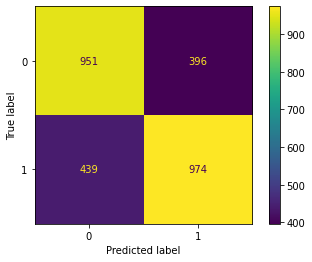

              precision    recall  f1-score   support

         0.0    0.68417   0.70601   0.69492      1347
         1.0    0.71095   0.68931   0.69996      1413

    accuracy                        0.69746      2760
   macro avg    0.69756   0.69766   0.69744      2760
weighted avg    0.69788   0.69746   0.69750      2760



In [36]:
report = evaluate(model, test_df)